Flow:


1. Load config file (provide path to saved model! as well as path to images on which to try - probe_images_small)
2. Modify train function, in case of inference, to return the test_loader and the model
3. Write the function for showing bbox on images
4. Iterate over the test_loader, and with every prediction, draw an image (we're relying on probe_images_small being small)

We can also introduce a flag in cfg, if we want to run test (so just inference), or we want to return the model and test_loader for demo (call it demo flag in cfg)

This notebook demonstrates the inference process for the trained model, focusing on generating and visualizing predictions. The workflow is structured as follows:

1. Load Configuration File:
Provide the path to the saved model.
Specify the directory containing the input images for inference (e.g., probe_images_small).
2. Modify the Training Function:
Update the train function to support inference by returning both the test_loader and the trained model.
Bounding Box Visualization:
3. Implement a utility function to overlay bounding boxes on input images based on the model’s predictions.
Inference and Visualization:
4. Iterate through the test_loader.
For each batch, perform inference and visualize the predicted bounding boxes on the corresponding images.
This workflow assumes probe_images_small contains a manageable number of images for rapid testing and visualization.

In [48]:
from utils.utils import load_config_omega

"""
Add path to the config file for the demo. Most things have been set up for you, you would just need to change the path to the data you'd like to use.
Also things, such as local_rank, and world_size, have been added to it (even though we're not going to be using them, there are some methods that check for them
even in the undistributed case).

There aren't any safeguards in place for incorrect paths, or playing with the other parameters in the config file. This would have been out of scope for this demo.
Either way, you won't mess with the traing, or the model, or the data, just with the loggers
"""
path = "configs/demo_inference.yaml"
config = load_config_omega(path)

In [49]:
config

{'random_seed': 42, 'output_path': 'experiments/results', 'experiment_name': 'baseline', 'save_model': False, 'inference': True, 'demo': True, 'data': {'name': 'probe_images', 'root_dir': 'datasets/probe_images_small', 'batch_size': 24, 'num_workers': 6}, 'model': {'model': 'vgg16', 'tag': 'flyability', 'num_classes': 2, 'save_model_path': 'experiments/saved_models', 'load_model_path': 'experiments/results/vgg16/20250109-223606_8c5e7/20250109-223606_8c5e7.pth'}, 'optimizer': {'lr': 0.001, 'weight_decay': 0, 'optimizer': 'adam', 'decrease_every': 150, 'lr_divisor': 2}, 'training': {'epochs': 20, 'validate_per_epoch': 2, 'loss': 'mse', 'apply_augmentation': False}, 'logging': {'project': 'Flybility', 'mode': 'disabled'}, 'distributed': {'use_distributed': False, 'backend': 'nccl', 'local_rank': 0, 'world_size': 1}}

In [50]:
from utils.workers import train
"""
    Here we assume you will provide a different set of images, than the ones used for training. As nowhere is it logged which images were used for training (which
    could be modified if needed), but when I was running it, I was using a preselected subset of "interesting" images. Nowhere did I check whether the model had
    seen these images for training. Ofc I could have taken them out of the original set, and then train_test_split it, but I didn't as I already had little images 
    to work with. And frankly, you'll probably just use a holdout set anyway, so it's not that big of a deal.
"""
model, test_loader, metrics = train(config)

Using CPU
Cache dir: experiments/results/vgg16/20250110-000819_ce8f7/wandb/.cache/wanb


Loading probe images dataset.


/opt/anaconda3/envs/flyability/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/flyability/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Test epoch 21: 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]

Epoch 20 logged.

TRAINING FINISHED!
DEMO MODE ACTIVATED! END OF TRAINING!


In [51]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [61]:
import os
from PIL import Image, ImageDraw, ImageFont

"""
    We need to resize the predictions, and the targets, to the size of the image, so we can draw the bounding boxes on it.
"""
width = 640
height = 400

def draw_bounding_boxes(image, pred_bbox, target_bbox):
    """
        Taken, and modified, from https://learnopencv.com/fine-tuning-faster-r-cnn/
    """
    draw = ImageDraw.Draw(image)
    font_size = int(min(image.size) * 0.02)  # Adjust font size based on image size
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font = ImageFont.truetype(font_path, font_size) if os.path.exists(font_path) else ImageFont.load_default()
 
    x1, y1, x2, y2 = pred_bbox
    draw.rectangle([
        x1 * width, 
        y1 * height, 
        x2 * width, 
        y2 * height
    ], outline='green', width=4)
    draw.text((x1, y1 - font_size), "pred", fill='green', font=font)

    x1, y1, x2, y2 = target_bbox
    draw.rectangle([
        x1 * width, 
        y1 * height, 
        x2 * width, 
        y2 * height
    ], outline='white', width=4)
    draw.text((x1, y1 - font_size), "true", fill='white', font=font)

    return image

datasets/probe_images_small


Demo:   0%|          | 0/1 [00:00<?, ?it/s]

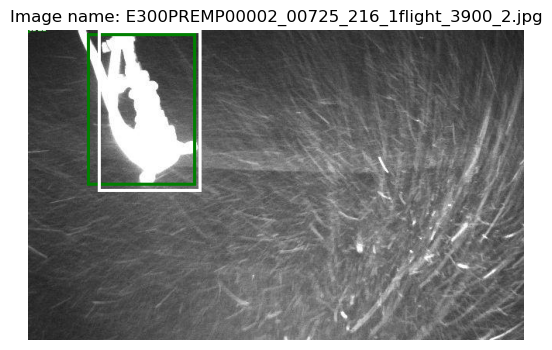

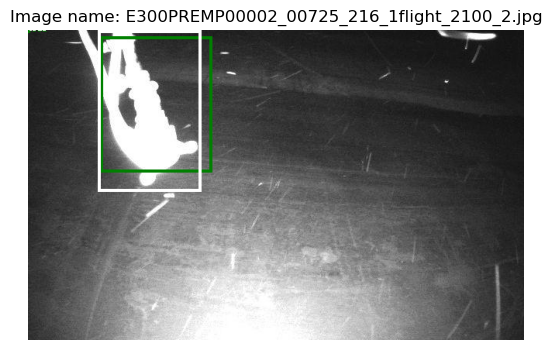

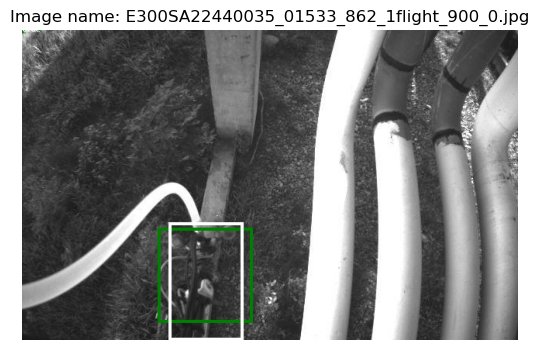

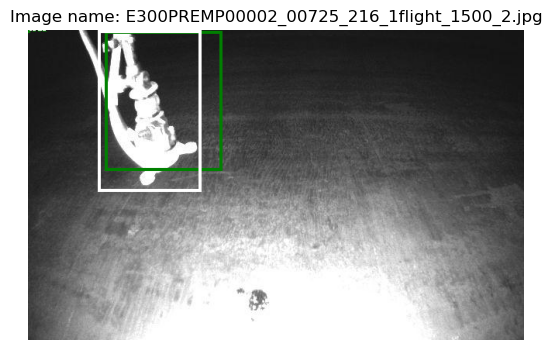

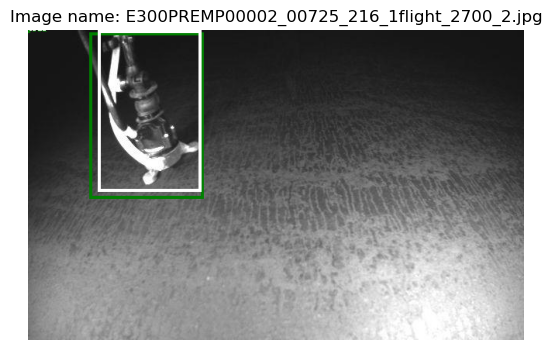

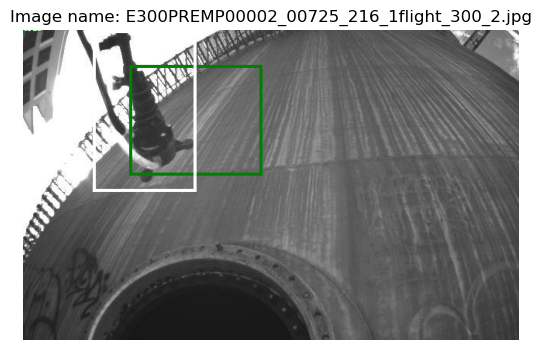

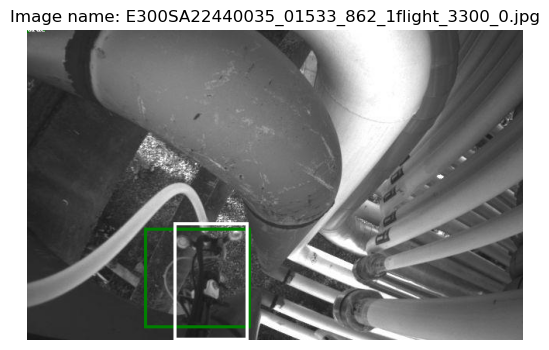

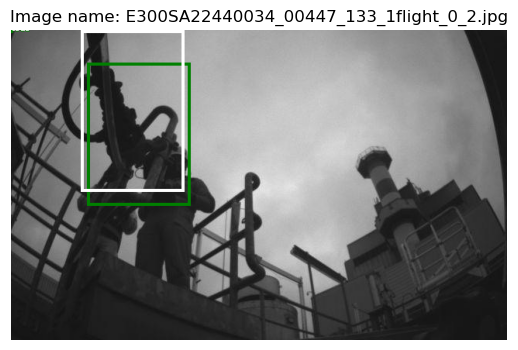

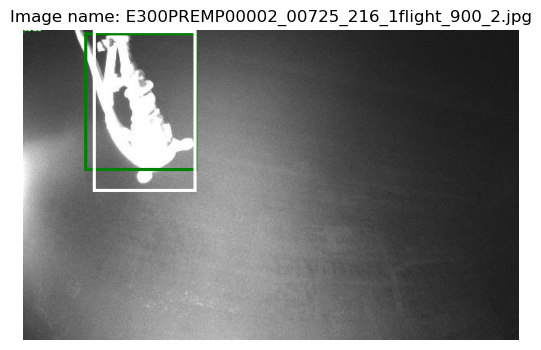

Demo: 100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


In [62]:
import torch
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_to_images = config.data.root_dir
print(path_to_images)

with torch.no_grad():
        for _, batch in enumerate(tqdm(test_loader, desc="Demo", leave=True, position=0)):
            images, image_names, targets = batch
            # Forward pass
            outputs = model(images.to(device, non_blocking=True))

            for idx, img_name in enumerate(image_names):
                image_path = os.path.join(path_to_images, img_name)
                image = Image.open(image_path)
                target_bbox = targets[idx]
                pred_bbox = outputs[idx]
                output_image = draw_bounding_boxes(image, pred_bbox, target_bbox)

                plt.imshow(output_image)
                plt.axis('off')
                plt.title(f"Image name: {img_name}")
                plt.show()
            
